In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import wordcloud as wc

In [3]:
version2_path = "../data/raw/td_V2.db"
con2 = sqlite3.connect(version2_path)

In [5]:
light_q = """SELECT key
     FROM jira_issues"""

heavy_q = """SELECT *
     FROM jira_issues"""

commits_q = """SELECT *
    FROM git_commits"""

In [6]:
light1 = pd.read_sql(light_q, con2)

In [7]:
heavy1 = pd.read_sql(heavy_q, con2)

In [8]:
heavy1.describe()

,PROJECT_ID,KEY,PRIORITY,TYPE,SUMMARY,DESCRIPTION,CREATION_DATE,RESOLUTION_DATE,HASH,COMMIT_DATE
count,30147,30147,30147,30147,30147,30147,30147,30147,30147,30147
unique,29,30147,6,14,30053,27491,30145,29942,29395,29380
top,org.apache:hive,HIVE-22657,Major,Bug,LLAP: merge master into branch,,2015-09-23 23:03:33 +0000,2013-06-08 03:15:45 +0000,f7defd32d8075bbc6d6f41b0482e8aa8775ce7ab,2014-12-09 14:28:20 +0000
freq,14024,1,21670,16405,19,2567,2,8,24,24


In [9]:
heavy1.columns

Index(['PROJECT_ID', 'KEY', 'PRIORITY', 'TYPE', 'SUMMARY', 'DESCRIPTION',
       'CREATION_DATE', 'RESOLUTION_DATE', 'HASH', 'COMMIT_DATE'],
      dtype='object')

## Initial exploration

In [10]:
heavy1.columns

Index(['PROJECT_ID', 'KEY', 'PRIORITY', 'TYPE', 'SUMMARY', 'DESCRIPTION',
       'CREATION_DATE', 'RESOLUTION_DATE', 'HASH', 'COMMIT_DATE'],
      dtype='object')

In [11]:
len(set(heavy1["KEY"])), len(heavy1)

(30147, 30147)

In [12]:
full_text = heavy1["DESCRIPTION"].to_string()

In [13]:
full_text2 = ""
for i, row in heavy1.iterrows():
    full_text2 += row["DESCRIPTION"] + " "
    

In [14]:
my_word_cloud = wc.WordCloud(background_color="white").generate(full_text)

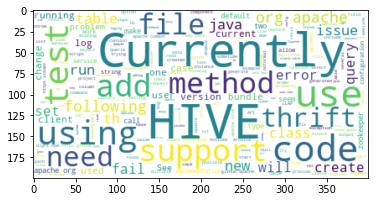

In [15]:
plt.imshow(my_word_cloud, interpolation='bilinear')
plt.show()

- contar nans del text
- contar nans de data ini, data fi, data due
- histograma de les longituds dels textos

## Data quality

In [16]:
# number of null descriptions
print("NA values:", sum(heavy1["DESCRIPTION"].isna()))
proportion = sum(heavy1["DESCRIPTION"]=="") / len(heavy1)
print("Empty values:", sum(heavy1["DESCRIPTION"]==""), f" Proportion:{proportion:.03}")
print("All the values:", len(heavy1))

NA values: 0
Empty values: 2567  Proportion:0.0851
All the values: 30147


In [17]:
# number of null descriptions
print("NA values:", sum(heavy1["SUMMARY"].isna()))
proportion = sum(heavy1["SUMMARY"]=="") / len(heavy1)
print("Empty values:", sum(heavy1["SUMMARY"]==""), f" Proportion:{proportion:.03}")
print("All the values:", len(heavy1))

NA values: 0
Empty values: 0  Proportion:0.0
All the values: 30147


In [18]:
# number of null dates
variable = "CREATION_DATE"
print(variable)
print("NA values:", sum(heavy1[variable].isna()))
proportion = sum(heavy1[variable]=="") / len(heavy1)
print("Empty values: ", sum(heavy1[variable]==""), f"Proportion: {proportion:.03}")

CREATION_DATE
NA values: 0
Empty values:  0 Proportion: 0.0


In [19]:
# number of null dates
variable = "RESOLUTION_DATE"
print(variable)
print("NA values:", sum(heavy1[variable].isna()))
proportion = sum(heavy1[variable]=="") / len(heavy1)
print("Empty values: ", sum(heavy1[variable]==""), f"Proportion: {proportion:.03}")

RESOLUTION_DATE
NA values: 0
Empty values:  0 Proportion: 0.0


In [20]:
# number of null types
print("NA values:", sum(heavy1["TYPE"].isna()))
proportion = sum(heavy1["TYPE"]=="") / len(heavy1)
print("Empty values:", sum(heavy1["TYPE"]==""), f" Proportion:{proportion:.03}")
print("All the values:", len(heavy1))

NA values: 0
Empty values: 0  Proportion:0.0
All the values: 30147


In [21]:
# number of null types
print("NA values:", sum(heavy1["PROJECT_ID"].isna()))
proportion = sum(heavy1["PROJECT_ID"]=="") / len(heavy1)
print("Empty values:", sum(heavy1["PROJECT_ID"]==""), f" Proportion:{proportion:.03}")
print("All the values:", len(heavy1))

NA values: 0
Empty values: 0  Proportion:0.0
All the values: 30147


## Attributes distribution

In [22]:
import matplotlib.pyplot as plt

### Texts lengths

In [23]:
desc_lens = heavy1["DESCRIPTION"].apply(lambda x: len(x.split(" ")))
desc_no_outlier_lens = desc_lens[desc_lens< 20_000]

sum_lens = heavy1["SUMMARY"].apply(lambda x: len(x.split(" ")))
sum_no_outlier_lens = sum_lens[sum_lens< 40_000]

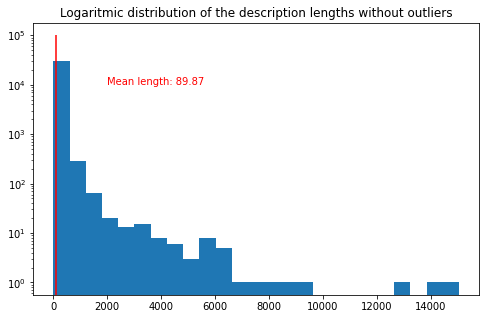

In [24]:
plt.figure(figsize=(8,5))
plt.hist(desc_no_outlier_lens, log=True, bins = 25)
plt.vlines(np.mean(desc_no_outlier_lens), ymin=0, ymax = 10**5, colors="red")
plt.title('Logaritmic distribution of the description lengths without outliers')
plt.text(2000, 10**4, 'Mean length: '+str(round(np.mean(desc_no_outlier_lens),2)), color='red')
plt.show()

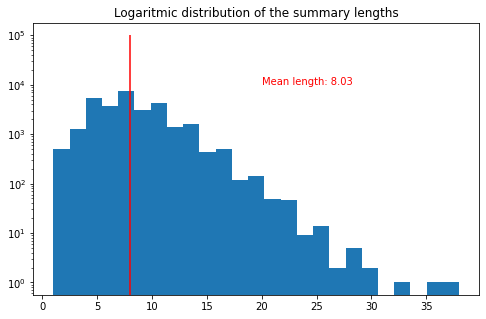

In [25]:
plt.figure(figsize=(8,5))
plt.hist(sum_no_outlier_lens, log=True, bins = 25)
plt.vlines(np.mean(sum_no_outlier_lens), ymin=0, ymax = 10**5, colors="red")
plt.title('Logaritmic distribution of the summary lengths')
plt.text(20, 10**4, 'Mean length: '+str(round(np.mean(sum_no_outlier_lens),2)), color='red')
plt.show()

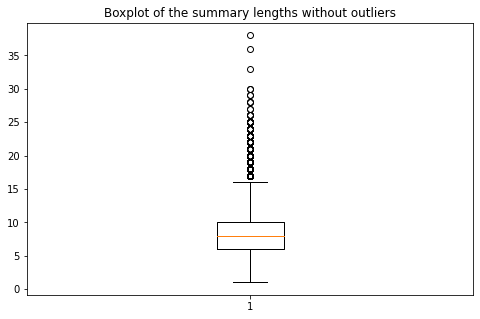

In [26]:
plt.figure(figsize=(8,5))
plt.boxplot(sum_no_outlier_lens)
plt.title('Boxplot of the summary lengths without outliers')
plt.show()

### Time distribution

In [27]:
import datetime as dt

def parse_date(x):
    if x == "":
        return dt.datetime(2000, 1,1)
    return dt.datetime.strptime(x.split(" ")[0], '%Y-%m-%d')

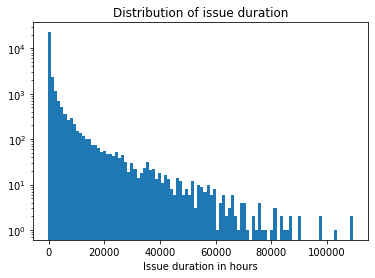

In [28]:
durations = heavy1["RESOLUTION_DATE"].apply(parse_date) - heavy1["CREATION_DATE"].apply(parse_date)
heavy1["duration"] = [d.days*24 + d.seconds/3600 if d.days > 0 else -100 for d in durations]
plt.hist(heavy1["duration"], bins=100, log=True, stacked=True);
plt.title('Distribution of issue duration')
plt.xlabel('Issue duration in hours')
plt.show()

### Relation between duration and lengths

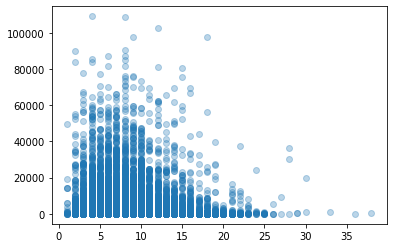

In [30]:
plt.scatter(sum_lens, heavy1['duration'], alpha=0.3)
plt.show()

### Categorical distribution

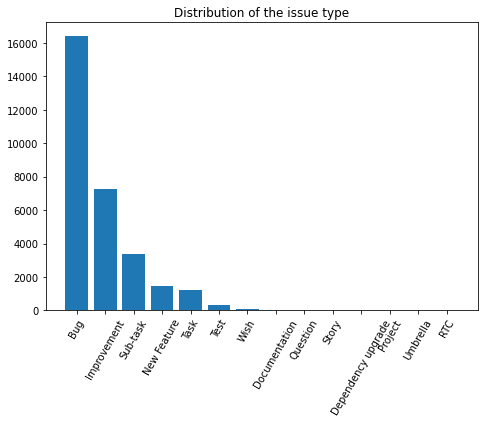

In [31]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
type = list(pd.DataFrame(pd.value_counts(heavy1['TYPE'])).index)
freq = pd.DataFrame(pd.value_counts(heavy1['TYPE'])).TYPE
ax.bar(type,freq)
plt.xticks(rotation=60)
plt.title('Distribution of the issue type')
plt.show()

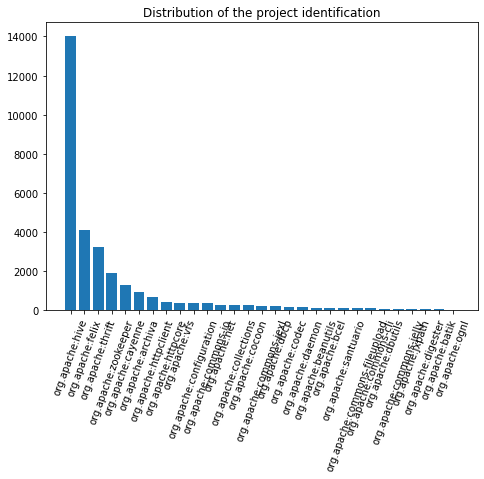

In [32]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
proj = list(pd.DataFrame(pd.value_counts(heavy1['PROJECT_ID'])).index)
freq = pd.DataFrame(pd.value_counts(heavy1['PROJECT_ID'])).PROJECT_ID
ax.bar(proj,freq)
plt.xticks(rotation=70)
plt.title('Distribution of the project identification')
plt.show()

# Word clouds

### Summaries

In [33]:
text_data = heavy1[["SUMMARY", "RESOLUTION_DATE", "CREATION_DATE"]].copy()
text_data = text_data[text_data['RESOLUTION_DATE'] != ""].copy()
text_data['dur'] = heavy1["RESOLUTION_DATE"].apply(parse_date) - heavy1["CREATION_DATE"].apply(parse_date)
text_data['dur'] = [d.days for d in text_data['dur']]
perc25 = np.percentile(list(text_data['dur']), 25)
perc75 = np.percentile(list(text_data['dur']), 75)
txt1 = " ".join(list(text_data[text_data['dur'] >= perc75].copy()['SUMMARY']))
txt2 = " ".join(list(text_data[text_data['dur'] <= perc25].copy()['SUMMARY']))

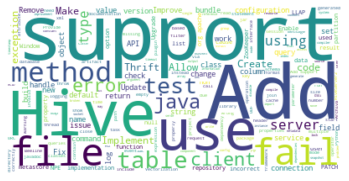

In [34]:
wc1 = wc.WordCloud(background_color="White").generate(txt1)
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.show()

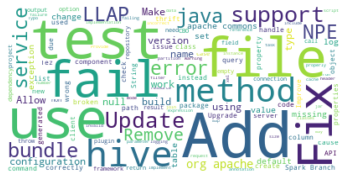

In [35]:
wc1 = wc.WordCloud(background_color="White").generate(txt2)
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [36]:
heavy1[heavy1['PROJECT_ID']=='commons-net']

,PROJECT_ID,KEY,PRIORITY,TYPE,SUMMARY,DESCRIPTION,CREATION_DATE,RESOLUTION_DATE,HASH,COMMIT_DATE,duration


In [37]:

perc25

1.0

### Descriptions

(-0.5, 399.5, 199.5, -0.5)

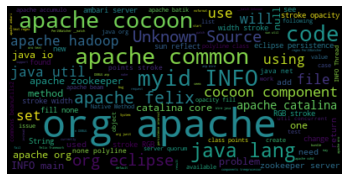

In [44]:
text_data = heavy1[["description", "resolutionDate", "creationDate"]].copy()
text_data = text_data[text_data['resolutionDate'] != ""].copy()
text_data['dur'] = heavy1["resolutionDate"].apply(parse_date) - heavy1["creationDate"].apply(parse_date)
text_data['dur'] = [d.days for d in text_data['dur']]
perc25 = np.percentile(list(text_data['dur']), 25)
perc75 = np.percentile(list(text_data['dur']), 75)
txt1 = " ".join(list(text_data[text_data['dur'] >= perc75].copy()['description']))
txt2 = " ".join(list(text_data[text_data['dur'] <= perc25].copy()['description']))
wc1 = wc.WordCloud().generate(txt1)
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

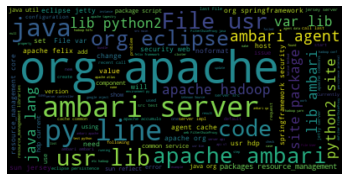

In [45]:
wc1 = wc.WordCloud().generate(txt2)
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")

# TF-idf + PCA

In [1]:
import re
text_data['summary_preproc'] = text_data['SUMMARY'].map(lambda x: re.sub('[,\.!?]', '', x))
text_data['summary_preproc'] = text_data['SUMMARY'].map(lambda x: x.lower())
text_data['SUMMARY'].head()

NameError: name 'text_data' is not defined

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer=TfidfVectorizer(use_idf=True)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(list(text_data['SUMMARY']))
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[1]
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head(45)

,tfidf
findbugs,0.492386
creation,0.426646
errors,0.405085
site,0.384455
maven,0.369782
fails,0.271998
with,0.230018
propertiesutil,0.000000
property_value_attributes,0.000000
property_modes,0.000000


In [52]:
tfidf_vectorizer_vectors[1].T.todense()

matrix([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [53]:
from sklearn.decomposition import PCA, TruncatedSVD

pca = TruncatedSVD(n_components=2, n_iter=10)
pca.fit(tfidf_vectorizer_vectors)


TruncatedSVD(n_iter=10)

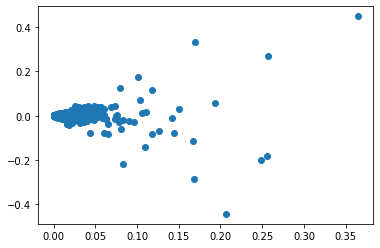

In [54]:
pca.components_.T
plt.scatter(pca.components_[0,:], pca.components_[1,:])

## Exploring the commits dataset

In [11]:
commit_changes = pd.read_sql("SELECT * FROM git_commits_changes", con2)

In [46]:
commit_changes.shape

(857740, 8)

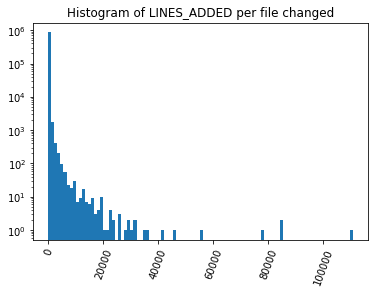

In [39]:
plt.hist(commit_changes['LINES_ADDED'].astype(int), bins=100, log=True)
plt.title("Histogram of LINES_ADDED per file changed")
plt.xticks(rotation=70);

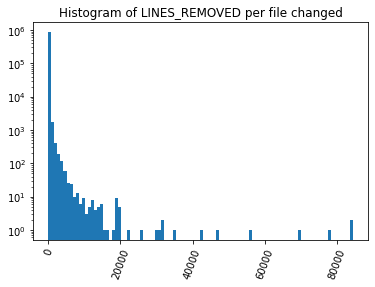

In [38]:
plt.hist(commit_changes['LINES_REMOVED'].astype(int), bins=100, log=True)
plt.title("Histogram of LINES_REMOVED per file changed")
plt.xticks(rotation=70);

Text(0, 0.5, 'lines removed')

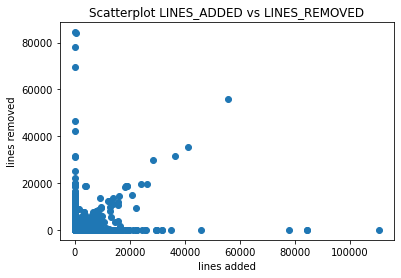

In [44]:
plt.scatter(commit_changes['LINES_ADDED'].astype(int), commit_changes['LINES_REMOVED'].astype(int))
plt.title('Scatterplot LINES_ADDED vs LINES_REMOVED')
plt.xlabel('lines added')
plt.ylabel('lines removed');

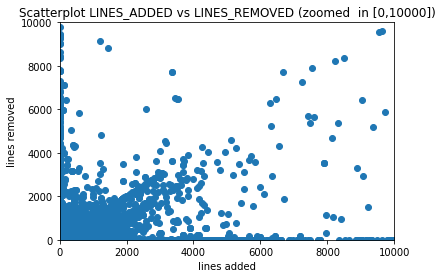

In [45]:
plt.scatter(commit_changes['LINES_ADDED'].astype(int), commit_changes['LINES_REMOVED'].astype(int))
plt.xlim(0,10000);
plt.ylim(0,10000);
plt.title('Scatterplot LINES_ADDED vs LINES_REMOVED (zoomed  in [0,10000])')
plt.xlabel('lines added')
plt.ylabel('lines removed');